# Nutrition Label Detection

Optical Character Recognition ( OCR ) ปัจจุบันมี Library OCR หลายตัว แต่ที่เราจะใช้ในการทำ Nutrition Label ก็คือ [Tesseract OCR ](https://opensource.google.com/projects/tesseract) ซึ่งจะทำการแปลง Image เป็น Text โดยหลังจากที่ทำการแปลงเสร็จเรียบร้อยแล้ว เราจะมาทำการ Normalize ก่อนเก็บลงในไฟล์ ซึ่งความสามารถของ Tesseract OCR ยังรองรับภาษาได้อีกหลายภาษา

In [ ]:
! pip install tensorflow==1.5
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 44.4MB 775kB/s 
     |████████████████████████████████| 3.0MB 31.7MB/s 
     |████████████████████████████████| 890kB 38.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.5.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1
1.5.0


In [ ]:
! apt-get install tesseract-ocr tesseract-ocr-tha libtesseract-dev -y
! pip install pytesseract opencv-contrib-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd tesseract-ocr-tha
0 upgraded, 6 newly installed, 0 to remove and 6 not upgraded.
Need to get 8,448 kB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get

In [ ]:
! tesseract --version

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [ ]:
! tesseract --list-langs

List of available languages (3):
osd
eng
tha


In [ ]:
! git clone https://github.com/natthasath/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 130 (delta 1), reused 130 (delta 1), pack-reused 0
Receiving objects: 100% (130/130), 16.53 MiB | 41.59 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
! tesseract '/content/dataset/nutrition/ocr_eng_01.jpg' read -l eng

Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Estimating resolution as 276


## OEM & PSM
บน OCR จะสามารถเลือก OCR Engine Mode (OEM) ได้ โดยต่ละโหมดจะใช้ Algorithm ที่แตกต่างกันในการ Recognization Character ซึ่งเราสามารถเปลี่ยนไปใช้ LSTM หรือ Neural Net ได้ แบ่งเป็น 4 โหมด
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available
  
 ส่วนสุดท้ายคือ Page Segmentation คือส่วนที่สำคัญที่สุด แบ่งออกเป็น 11 โหมด

In [ ]:
! tesseract '/content/dataset/nutrition/ocr_eng_01.jpg' read_lstm -l eng --oem 3 --psm 3

Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Estimating resolution as 276


## Object Detection
ในการทำ Nutrition Label ครั้งนี้ จะใช้ Base Line จาก [Tensorflow Model Research](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)
ถ้าใช้ Tensorflow 1.3+ จะต้องทำการรันคำสั่งด้านล่าง แล้วทำการเรียก Python Library ใหม่ โดยใช้  object_detection.utils แทนการเรียก utils [https://github.com/tensorflow/models/issues/1990](https://github.com/tensorflow/models/issues/1990)

---

```
! git clone https://github.com/tensorflow/models.git
% cd /content/models/research
! protoc object_detection/protos/*.proto --python_out=.
```

---


In [ ]:
! git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 26765 (delta 26), reused 17 (delta 12), pack-reused 26716
Receiving objects: 100% (26765/26765), 508.95 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (16213/16213), done.
Checking out files: 100% (2983/2983), done.


In [ ]:
% cd /content/models/research
! protoc object_detection/protos/*.proto --python_out=.

/content/models/research


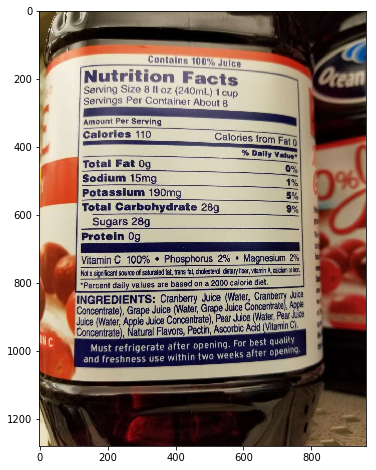

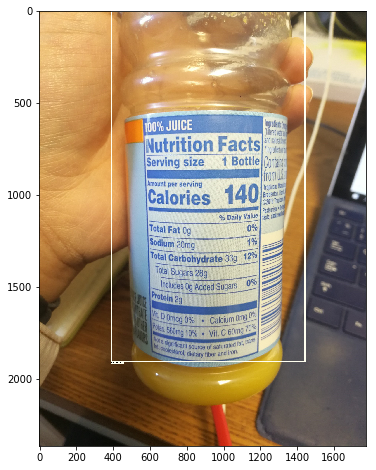

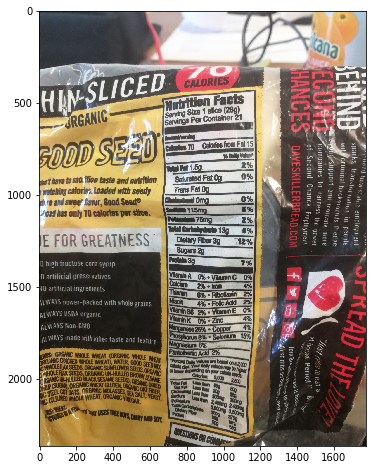

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
  
# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

# Download Model
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

# Load a Frozen Tensorflow Model into Memory
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
# Loading Label Map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Helper Code
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/dataset/nutrition/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'ocr_eng_0{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## Text Detection & Extraction
หลังจากที่ทำ Object Detection ต่อมาสิ่งที่เราต้องทำคือ Text Detection & Extraction โดยใช้ [Connectionist Text Proposal Network (CTPN)](https://github.com/eragonruan/text-detection-ctpn) ซึ่งใช้ Algorithm แบบ [Fast R-CNN](https://docs.microsoft.com/en-us/cognitive-toolkit/object-detection-using-fast-r-cnn) ในการ Extract ระหว่าง Textual Region ในรูปภาพ ในอนาคตเรายังสามารถปรับปรุงในเรื่องของ Faster และ Accurate ให้มีประสิทธิภาพดีมากยิ่งขึ้น สามารถดู [Open DNN Example](https://github.com/opencv/opencv/blob/master/samples/dnn/text_detection.py) แต่ก่อนที่จะใช้ Base Line เราจะต้องทำการแก้ [Argparse on Jupyter Notebook](https://towardsdatascience.com/learn-enough-python-to-be-useful-argparse-e482e1764e05)

In [ ]:
# https://github.com/spyder-ide/spyder/issues/3883
import sys; sys.argv=['']; del sys
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args()